In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
'''predefine '''
VALID_MOD = ['bpsk', 'qpsk', '8psk']

BPSK_SYM = np.array([-1+0j,1+0j])
# QPSK_SYM = (np.sqrt(2) / 2) * np.array([1+1j, 1-1j, -1+1j, -1-1j])

QPSK_SYM = np.array([
    np.exp(1j * np.pi / 4),      # 45 degrees
    np.exp(1j * 3 * np.pi / 4),  # 135 degrees
    np.exp(1j * 5 * np.pi / 4),  # 225 degrees
    np.exp(1j * 7 * np.pi / 4),  # 315 degrees
])

EPSK_SYM = np.array([
    np.exp(1j * np.pi     / 4),  # 45 degrees
    np.exp(1j * 3 * np.pi / 4),  # 135 degrees
    np.exp(1j * 5 * np.pi / 4),  # 225 degrees
    np.exp(1j * 7 * np.pi / 4),  # 315 degrees
    np.exp(1j * np.pi     / 12),     # 15 degrees
    np.exp(1j * 5 * np.pi / 12),  # 75 degrees
    np.exp(1j * 9 * np.pi / 12),  # 135 degrees
    np.exp(1j * 13 *np.pi / 12)  # 195 degrees
])

# todo add QAM


In [3]:
def _valid_check(mod_typ:str):
    '''check if the modulation type are supported'''
    assert mod_typ in VALID_MOD, f"not supported mode type {mod_typ}"
    pass

In [4]:
def symbol_rate (mod_typ = 'bpsk'):
    if    mod_typ == 'bpsk': return 2
    elif  mod_typ == 'qpsk': return 4
    elif  mod_typ == '8psk': return 6
    else:  return None

In [5]:
def gen_pattern (mod_typ = 'bpsk'):
    if    mod_typ == 'bpsk': return BPSK_SYM
    elif  mod_typ == 'qpsk': return QPSK_SYM
    elif  mod_typ == '8psk': return EPSK_SYM
    else:  return None

In [6]:
def bits_to_symbols(bits, mod_type='bpsk'):
    _valid_check(mod_type)
    bit_num_per_symbol = symbol_rate (mod_type)
    if mod_type == 'bpsk':   target_symbols = BPSK_SYM
    elif mod_type == 'qpsk': target_symbols = QPSK_SYM
    elif mod_type == '8psk': target_symbols = EPSK_SYM
    else:
        pass
    
    symbols = []
    for i in range(0, len(bits), bit_num_per_symbol):
        symbol_bits = bits[i:i+bit_num_per_symbol]
        if mod_type == 'bpsk':
            symbol = np.array([-1 + 0j]) if symbol_bits[0] else np.array([1 + 0j])
        elif mod_type == 'qpsk':
            phase  = np.pi / 4 * (2 * symbol_bits[0] + symbol_bits[1])
            symbol = np.array([np.exp(1j * phase)])
        elif mod_type == '8psk':
            gray_code = symbol_bits.dot(2 ** np.arange(len(symbol_bits)))
            phase = 2 * np.pi * gray_code / 8
            symbol = np.array([np.exp(1j * phase)])
        symbols.append(symbol)
    
    return symbols

    

In [7]:
def gen_binary_signal(num_bits, pattern=None):
    if pattern is None:
        signal = np.random.randint(0, 2, num_bits)
    else:
        pattern_len = len(pattern)
        repetitions = num_bits // pattern_len
        signal = np.tile(pattern, repetitions)
        remainder = num_bits % pattern_len
        signal = np.concatenate((signal, pattern[:remainder]))
    return signal

In [8]:
# Example usage:
num_bits = 4

# Generate a signal with a random pattern
random_binary_signal = gen_binary_signal(num_bits)
print("Random Pattern:", random_binary_signal)

# Generate a signal with a specified pattern
custom_pattern = [0, 1]
custom_binary_signal = gen_binary_signal(num_bits, pattern=custom_pattern)
print("Custom Pattern:", custom_binary_signal)

Random Pattern: [1 0 0 1]
Custom Pattern: [0. 1. 0. 1.]


In [9]:
def gen_raw_signal(num_symbs, pattern=None, mod_typ='bpsk'):
    _valid_check(mod_typ)
    bit_num_per_symbol = symbol_rate (mod_typ)
    num_bits = num_symbs * bit_num_per_symbol
    bin_signal = gen_binary_signal(num_bits, pattern)
    symbols = bits_to_symbols(bin_signal, mod_typ)
#     print(symbols)
    
    return symbols
    

In [10]:
# Example usage:
num_symbls = 4

# Generate a signal with a random pattern
random_symbol_signal = gen_raw_signal(num_symbls, None, 'qpsk')
print("Random Pattern:", random_symbol_signal)
print(f"Length = {len(random_symbol_signal)}\n")

# Generate a signal with a specified pattern
custom_pattern = [0, 1]
custom_binary_signal = gen_raw_signal(num_symbls, custom_pattern, 'qpsk')
print("Custom Pattern:", custom_binary_signal)
print(f"Length = {len(custom_binary_signal)}")

Random Pattern: [array([6.123234e-17+1.j]), array([6.123234e-17+1.j]), array([-0.70710678+0.70710678j]), array([0.70710678+0.70710678j])]
Length = 4

Custom Pattern: [array([0.70710678+0.70710678j]), array([0.70710678+0.70710678j]), array([0.70710678+0.70710678j]), array([0.70710678+0.70710678j])]
Length = 4


In [11]:
def bb_gen_1(duration, random_pattern=True, mod_typ = 'bpsk'):
    """
    Generate a BPSK signal.

    Parameters:
        duration (float): Duration of the signal in seconds.
        random_pattern (True or False): If True, generate a list of 0s and 1s randomly, otherwise by [0,1].

    Returns:
        np.array: BPSK signal values.
    """
    symbol_rate = cal_symbol_rate(mod_typ)

    num_symbols = int(duration * symbol_rate)
    
    symbol_pattern = gen_pattern(mod_typ)
    
    if random_pattern:
        
        signal = np.random.choice(symbol_pattern, num_symbols)
    else:
        signal = np.tile(symbol_pattern, num_symbols // len(symbol_pattern))

    return signal

In [12]:
def bpsk_gen(duration, symbol_rate, random_pattern=True, fixed_pattern = [0, 1]):
    """
    Generate a BPSK signal.

    Parameters:
        duration (float): Duration of the signal in seconds.
        symbol_rate (float): Symbol rate in symbols per second.
        random_pattern (True or False): If True, generate a list of 0s and 1s randomly, otherwise by [0,1].

    Returns:
        np.array: BPSK signal values.
    """
    num_symbols = int(duration * symbol_rate)
    if random_pattern:
        
        signal = np.random.choice([0, 1], num_symbols)
    else:
        
        signal = np.tile(fixed_pattern, num_symbols // len(fixed_pattern))

    return signal

In [13]:
def upsample_bpsk_gen(duration, symbol_rate, random_pattern, upsample_factor=4, constant_value=1):
    """
    Generate an up-sampled BPSK signal with a constant value.

    Parameters:
        duration (float): Duration of the signal in seconds.
        symbol_rate (float): Symbol rate in symbols per second.
        random_pattern (True or False): If True, generate a list of 0s and 1s randomly, otherwise by [0,1].
        upsample_factor (int): Factor by which to up-sample the signal.
        constant_value (int): The constant value to use for the up-sampled signal.

    Returns:
        np.array: Up-sampled BPSK signal values.
    """
    signal = bpsk_gen(duration, symbol_rate, random_pattern)
    
    print(signal)
    
    upsampled_signal = np.repeat(signal, upsample_factor)
    
    print(upsampled_signal)
    
#     # Replace all values with the constant_value
#     upsampled_signal = np.where(upsampled_signal == 0, constant_value, upsampled_signal)
#     print(upsampled_signal)
    
    return upsampled_signal

In [14]:
def plot_timing(signal, symbol_rate):
    """
    Plot the BPSK signal over time.

    Parameters:
        signal (np.array): BPSK signal values.
        symbol_rate (float): Symbol rate in symbols per second.
    """
    plt.figure(figsize=(10, 3))
    time = np.arange(0, len(signal)) / symbol_rate
    plt.plot(time, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("BPSK Signal")
    plt.grid(True)
    plt.show()

In [15]:
# duration = 10  # Signal duration in seconds
# symbol_rate = 2  # Symbol rate in symbols per second
# random_pattern = False  # Use None for random pattern, or provide a fixed pattern as a list
# upsample_factor = 4

# # signal = upsample_bpsk_gen(duration, symbol_rate, random_pattern)
# signal = bb_gen(duration, random_pattern, 'qpsk')
# plot_timing(signal, symbol_rate)

In [16]:
# Create the QPSK symbol map:
# https://www.wavewalkerdsp.com/2022/06/08/building-a-psk-and-qam-modulator-in-python/
# QPSKMapper =(np.sqrt(2) / 2) * np.array([1+1j, 1-1j, -1+1j, -1-1j])

SymbolMapper = gen_pattern('qpsk')

In [17]:
def generate_rrc_filter(N, alpha):
    n = np.arange(-N/2, N/2)
    h = np.sinc(n) * np.cos(np.pi * alpha * n) / (1 - (2 * alpha * n)**2)
    return h / np.sum(h)

In [18]:
def filer_gen(type_n: str = 'rrc')
    if type_n == 'rrc': pass
#     pulseShape

SyntaxError: expected ':' (4237541674.py, line 1)

In [ ]:
def bb_gen_bak(symbol_num: int, upsample: int = 4):

    # Randomly generate some QPSK symbols:
#     ns = 16
    mapIndex = np.random.randint(0, len(SymbolMapper), symbol_num) 
    print(f"mapIndex={mapIndex}")
    Symbols = SymbolMapper[mapIndex]
    print(f"Symbols={Symbols}")
    # Define the samples per symbol, which is also the pulse shaping filter length:
#     upsample = 4
    # Upsample the symbols:

    SymbolsUpsampled = np.zeros(symbol_num*upsample, dtype = complex)

    print(f"SymbolsUpsampled = {SymbolsUpsampled}")
    SymbolsUpsampled[::upsample] = Symbols
    print(f"SymbolsUpsampled = {SymbolsUpsampled}")
    #Define the pulse shaping filter:

#     pulseShape = np.ones(upsample)
    
#     # Apply the pulse shaping filter:
#     Signal = np.convolve(SymbolsUpsampled, pulseShape)
    
    # Define the raised cosine pulse shaping filter

    alpha = 0.35  # Adjust alpha based on your needs
    num_symbols = symbol_num * upsample
    rrc_filter = generate_rrc_filter(num_symbols, alpha)
    print(f'rrc_filter = {rrc_filter}')
    Signal = np.convolve(SymbolsUpsampled, rrc_filter, mode='full')[:len(SymbolsUpsampled)]
    
    return Signal

In [ ]:
def bb_gen(symbol_num: int, upsample: int = 4):
    """
    Generate a Baseband digital modulated signal.

    Parameters:
        duration (float): Duration of the signal in seconds.
        symbol_rate (float): Symbol rate in symbols per second.
        random_pattern (True or False): If True, generate a list of 0s and 1s randomly, otherwise by [0,1].

    Returns:
        np.array: BPSK signal values.
    """
    # Randomly generate some QPSK symbols:
#     ns = 16
    mapIndex = np.random.randint(0, len(SymbolMapper), symbol_num) 
    print(f"mapIndex={mapIndex}")
    Symbols = SymbolMapper[mapIndex]
    print(f"Symbols={Symbols}")
    # Define the samples per symbol, which is also the pulse shaping filter length:
#     upsample = 4
    # Upsample the symbols:

    SymbolsUpsampled = np.zeros(symbol_num*upsample, dtype = complex)

    print(f"SymbolsUpsampled = {SymbolsUpsampled}")
    SymbolsUpsampled[::upsample] = Symbols
    print(f"SymbolsUpsampled = {SymbolsUpsampled}")
    #Define the pulse shaping filter:

#     pulseShape = np.ones(upsample)
    
#     # Apply the pulse shaping filter:
#     Signal = np.convolve(SymbolsUpsampled, pulseShape)
    
    # Define the raised cosine pulse shaping filter

    alpha = 0.35  # Adjust alpha based on your needs
    num_symbols = symbol_num * upsample
    rrc_filter = generate_rrc_filter(num_symbols, alpha)
    print(f'rrc_filter = {rrc_filter}')
    Signal = np.convolve(SymbolsUpsampled, rrc_filter, mode='full')[:len(SymbolsUpsampled)]
    
    return Signal

In [ ]:
complex_signal = bb_gen(8, 4)

In [ ]:
complex_signal

In [11]:
def plot_complex(complex_signal):
    # Separate the real and imaginary parts
    real_part = np.real(complex_signal)
    imaginary_part = np.imag(complex_signal)

    # Create timing bins (assuming 16 bins for your data)
    timing_bins = range(len(complex_signal))

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot the real part with "*" markers
    ax1.plot(timing_bins, real_part, label='Real Part', color='blue', marker='*')
    ax1.set_ylabel('Real Part')
    ax1.legend()
    ax1.grid(True)
    ax1.set_title('Real Part vs. Timing Bin')

    # Plot the imaginary part with "*" markers
    ax2.plot(timing_bins, imaginary_part, label='Imaginary Part', color='orange', marker='*')
    ax2.set_xlabel('Timing Bin')
    ax2.set_ylabel('Imaginary Part')
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Imaginary Part vs. Timing Bin')

    plt.tight_layout()
    plt.show()

In [12]:
def plot_const(complex_signal):
    # Separate the real and imaginary parts
    real_part = np.real(complex_signal)
    imaginary_part = np.imag(complex_signal)
    print(f"number of signal bin: {len(real_part)}")
    
    # Create a constellation plot
    plt.figure(figsize=(6, 6))
    plt.scatter(real_part, imaginary_part, marker='o', color='r')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Constellation Diagram')
    plt.grid(True)
    plt.show()

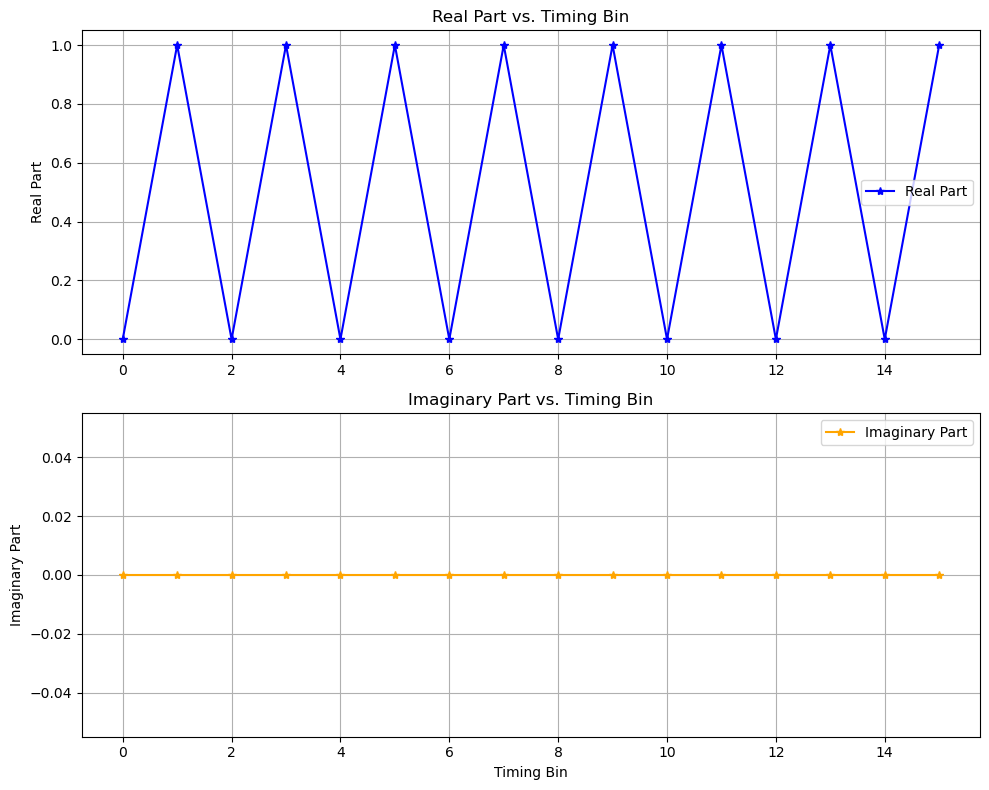

In [16]:
plot_complex(custom_binary_signal)

number of signal bin: 16


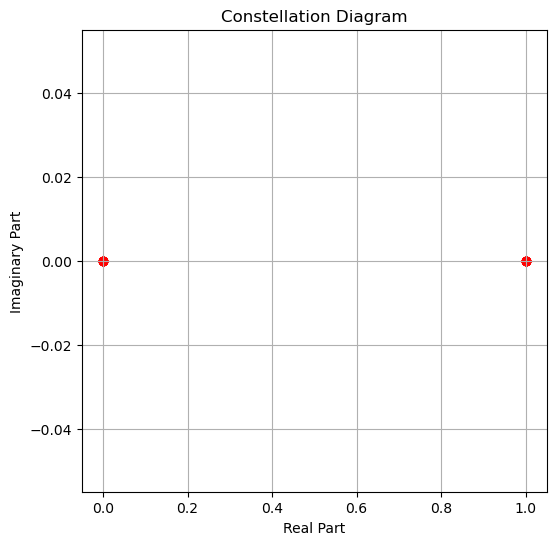

In [17]:
plot_const(custom_binary_signal)